# Visualize Real and Synthetic Data

This script provides the visual analysis of the synthetic time-series generator. There are seven ways to do analysis:
- **Diversity Assessment:** The distribution of the synthetic samples should roughly match that of the real data
    - PCA Visualization.
    - T-SNE Visualization.
- **Fidelity Assessment:** The sample series should be indistinguishable from the real data.
    - Real/Synthetic Data Classification.
- **Usefulness:** The synthetic data should be as useful as its real counterparts for solving the predictive task.
    - Train on Real, Test on Real (TRTR)
    - Train on Real, Test on Synthetic (TRTS)
    - Train on Synthetic, Test on Real (TSTR)
    - Train on Synthetic, Test on Synthetic (TSTS)

In [1]:
# Expand views
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [40]:
# Basic imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [3]:
# Set GPU/CPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


2022-05-02 11:23:30.272848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 11:23:30.272867: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 11:23:30.272881: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [4]:
# Set Seaborn Mode
sns.set_style('white')

In [5]:
results_path = Path('../../results')
if not results_path.exists():
    results_path.mkdir()

In [6]:
seq_len = 24
n_seq = 26

## Load Data

In [7]:
experiment = 0

In [8]:
df = pd.read_csv("../../../../../data/batadal_dataset03.csv")

In [9]:
# Get only float values
df = df[['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
         'F_PU1', 'F_PU2', 'F_PU4', 'F_PU7', 'F_PU8', 'F_PU10',
         'F_V2',
         'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 
         'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']]

In [10]:
features = list(df.columns)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)
real_data = []
for i in range(len(df) - seq_len):
    real_data.append(scaled_data[i:i + seq_len])

In [11]:
np.asarray(real_data).shape

(8737, 24, 26)

In [12]:
# Import synthetic data
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / 'generated_data_batadal.npy')
synthetic_data.shape

(8704, 24, 26)

In [13]:
# Reshape the real data to have the same shape as the synthetic data
real_data = real_data[:synthetic_data.shape[0]]
np.asarray(real_data).shape

(8704, 24, 26)

## 2. Prepare Sample

In [14]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [15]:
# Get 250 data points of each attributes each with the batch size of 24
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [16]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [17]:
real_sample_2d.shape, synthetic_sample_2d.shape

((6500, 24), (6500, 24))

## 3. Visualize Data in 2D: Qualitative Assessment of Diversity

### 3.1. PCA

In [18]:
pca = PCA(n_components=2) # 2D 
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d)).assign(Data="Real"))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d)).assign(Data="Synthetic"))
pca_result = pca_real.append(pca_synthetic).rename(columns={0: '1st Component', 1: '2nd Component'})

### 3.2. t-SNE

In [19]:
tsne_data = np.concatenate((real_sample_2d, synthetic_sample_2d), axis=0)
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

/home/mnguyen0226/anaconda3/envs/mtss_gan2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mnguyen0226/anaconda3/envs/mtss_gan2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13000 samples in 0.001s...
[t-SNE] Computed neighbors for 13000 samples in 3.956s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13000
[t-SNE] Computed conditional probabilities for sample 2000 / 13000
[t-SNE] Computed conditional probabilities for sample 3000 / 13000
[t-SNE] Computed conditional probabilities for sample 4000 / 13000
[t-SNE] Computed conditional probabilities for sample 5000 / 13000
[t-SNE] Computed conditional probabilities for sample 6000 / 13000
[t-SNE] Computed conditional probabilities for sample 7000 / 13000
[t-SNE] Computed conditional probabilities for sample 8000 / 13000
[t-SNE] Computed conditional probabilities for sample 9000 / 13000
[t-SNE] Computed conditional probabilities for sample 10000 / 13000
[t-SNE] Computed conditional probabilities for sample 11000 / 13000
[t-SNE] Computed conditional probabilities for sample 12000 / 13000
[t-SNE] Computed conditional probabilities for sa

In [20]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*26:, 'Data'] = 'Synthetic'

## 3.3. Plot Results

There are not much diversity but we can see that the synthetic data can capture the trend of the original dataset.

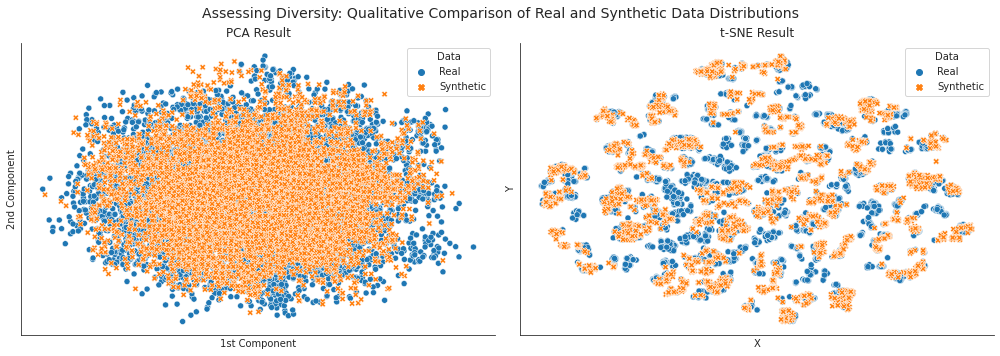

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Time Series Classification 
 
A quantitative assessment of Fidelity. We label each batch sample as either real or synthetic, then we train a classifier accordingly to see if it can distinguish between real or synthetic data. The lower the testing accuracy, the better it is.

We want to use bench-mark NLP/Time Series Architecture: GRU, LSTM, RNN, Transformers

## 1. Prepare Data

In [22]:
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(8704, 24, 26)

In [23]:
synthetic_data.shape

(8704, 24, 26)

In [24]:
n_series = real_data.shape[0]
n_series

8704

In [25]:
idx = np.arange(n_series)
idx

array([   0,    1,    2, ..., 8701, 8702, 8703])

In [26]:
n_train = int(.8*n_series) # Use 80% Training and 20% Testing
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [27]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [28]:
train_data.shape

(13926, 24, 26)

In [29]:
test_data.shape

(3482, 24, 26)

In [30]:
# Create labels: 1 is real, 0 is synthetic
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## 2. Create Classifier

Evaluate whether real and synthetic time series can be differentiated or are indistinguishable

In [35]:
ts_classifier = Sequential([GRU(6, input_shape=(24, 26), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [36]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [37]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 612       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 619
Trainable params: 619
Non-trainable params: 0
_________________________________________________________________


In [38]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [39]:
ts_classifier.evaluate(x=test_data, y=test_labels)

109/109 [==============================] - 0s 2ms/step - loss: 9.3546e-06 - AUC: 1.0000 - accuracy: 1.0000


[9.354575922770891e-06, 1.0, 1.0]

In [41]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [42]:
from matplotlib.ticker import FuncFormatter

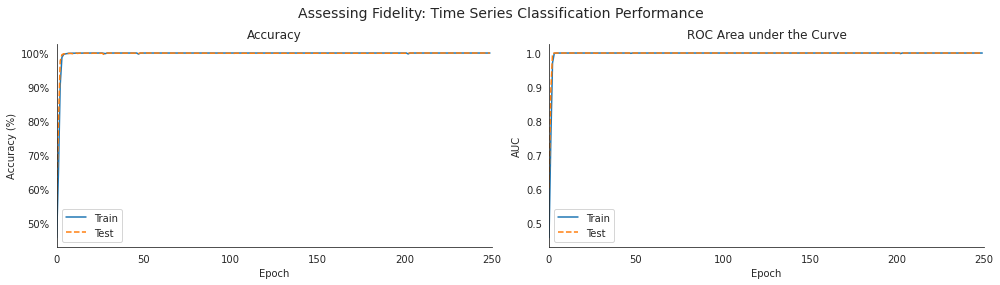

In [43]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Train on Synthetic, Test on Real (Regression Test)

- Others: 
    - Train on Real, Test on Real (check the classifier).
    - Train on Real, Test on Synthetic (check if the 2 Synthetic can fool the classifier).
    - Train on Synthetic, Test on Real (check if we can replace the Real for Synthetic in the training process).
    - Train on Synthetic, Test on Synthetic (check if we can replace the real dataset entirely)
- Take in a window and try to predict the next time step.  

In [44]:
real_data = real_data
real_data = np.array(real_data)[:len(synthetic_data)]

In [45]:
real_data.shape, synthetic_data.shape

((8704, 24, 26), (8704, 24, 26))

In [46]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [47]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((6963, 23, 26), (6963, 26), (1741, 23, 26), (1741, 26))

In [48]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [49]:
synthetic_train.shape, synthetic_label.shape

((8704, 23, 26), (8704, 26))

In [50]:
def get_model():
    model = Sequential([GRU(6, input_shape=(seq_len-1, n_seq)),
                        Dense(26)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [51]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [52]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [53]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

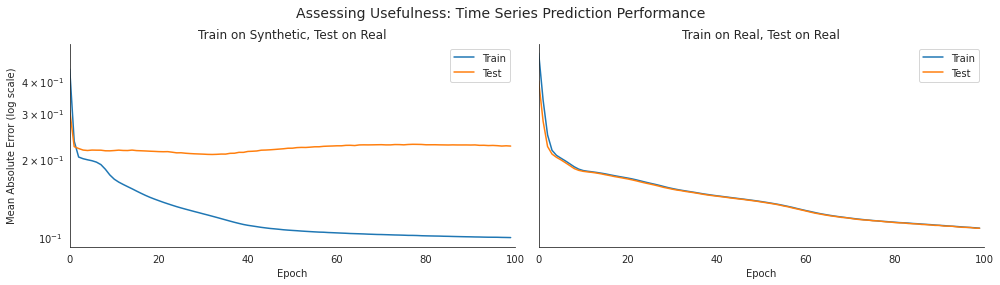

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);